In [1]:
# Task 1: Importing Libraries
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torch import nn, optim
from torchvision import transforms, datasets


In [2]:

# Task 2: Loading the Dataset
# Define data directories
train_data_path = "/kaggle/input/rock-paper-scissor/rock-paper-scissors/train"
test_data_path = "/kaggle/input/rock-paper-scissor/rock-paper-scissors/test"

# Define transforms to match MNIST preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Load Training Data
full_train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)


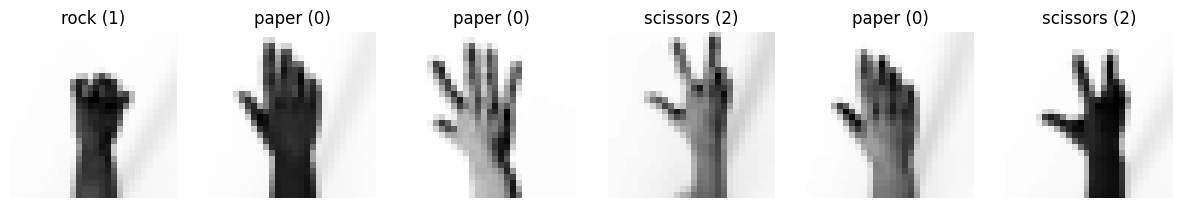

In [3]:

# Task 3: Exploratory Data Analysis (EDA)
def visualize_samples(dataset, num_samples=6):
    """Visualizes random samples from the dataset."""
    if isinstance(dataset, Subset):
        class_names = dataset.dataset.classes
        indices = np.random.choice(len(dataset), num_samples, replace=False)
        samples = [(dataset[i][0], dataset[i][1]) for i in indices]
    else:
        class_names = dataset.classes
        indices = np.random.choice(len(dataset), num_samples, replace=False)
        samples = [(dataset[i][0], dataset[i][1]) for i in indices]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    for i, (image, label) in enumerate(samples):
        image = image.numpy().squeeze()
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{class_names[label]} ({label})")
    plt.show()

visualize_samples(full_train_dataset)


In [5]:

# Task 4 & 5: Data Preprocessing and Splitting
# Stratified train-validation split
targets = [s[1] for s in full_train_dataset.samples]
train_indices, val_indices = train_test_split(
    range(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_train_dataset, val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Task 6: Building the Neural Network Model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, len(full_train_dataset.classes)))  # Output size equals number of classes

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Task 7: Training the Model
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += loss_function(outputs, labels).item()
                correct += (outputs.argmax(1) == labels).sum().item()
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {total_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val Acc: {100*correct/len(val_dataset):.2f}%\n")

train_model(model, train_loader, val_loader, epochs=10)

# Task 8: Preprocessing Test Data with Custom Dataset
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_dir, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_rel_path = self.image_paths[idx]
        img_full_path = os.path.join(self.root_dir, img_rel_path)
        image = Image.open(img_full_path).convert('L')
        if self.transform:
            image = self.transform(image)
        image_id = os.path.splitext(img_rel_path)[0].replace('/', '_')
        return image, image_id

test_dataset = TestDataset(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Task 9: Making Predictions
def make_predictions(model, test_loader):
    model.eval()
    image_ids, predictions = [], []
    with torch.no_grad():
        for images, ids in test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            preds = outputs.argmax(1).tolist()
            predictions.extend(preds)
            image_ids.extend(ids)
    return image_ids, predictions

image_ids, test_preds = make_predictions(model, test_loader)

# Task 10: Creating Submission File
submission = pd.DataFrame({'ImageId': image_ids, 'Label': test_preds})
submission.to_csv("submission.csv", index=False)
print("Submission file created.")

Epoch 1/10
Train Loss: 1.0797
Val Loss: 1.0373
Val Acc: 46.23%

Epoch 2/10
Train Loss: 0.9866
Val Loss: 0.9459
Val Acc: 56.15%

Epoch 3/10
Train Loss: 0.8769
Val Loss: 0.8462
Val Acc: 67.46%

Epoch 4/10
Train Loss: 0.7752
Val Loss: 0.7277
Val Acc: 75.00%

Epoch 5/10
Train Loss: 0.6614
Val Loss: 0.6308
Val Acc: 78.97%

Epoch 6/10
Train Loss: 0.5448
Val Loss: 0.5334
Val Acc: 89.48%

Epoch 7/10
Train Loss: 0.4820
Val Loss: 0.4673
Val Acc: 90.87%

Epoch 8/10
Train Loss: 0.4094
Val Loss: 0.4361
Val Acc: 88.49%

Epoch 9/10
Train Loss: 0.3671
Val Loss: 0.5182
Val Acc: 76.79%

Epoch 10/10
Train Loss: 0.3206
Val Loss: 0.3723
Val Acc: 89.29%

Submission file created.


UsageError: Line magic function `%git` not found.
